In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras.regularizers import l2

In [2]:
# Daten einlesen
data = pd.read_csv('model.csv')

In [3]:
data.head()

,R1_1,R1_3,R1_5,R1_7,R1_9,R1_11,R4_1,R4_3,R4_5,R4_7,R4_9,R4_11,class,activity
0,0.008886,0.002055,0.011719,0.008174,0.012429,0.038314,0.005472,0.012699,0.028841,0.005891,0.020939,0.015422,0,pause
1,0.007554,0.002742,0.012014,0.007784,0.012509,0.039015,0.005378,0.013017,0.028469,0.006077,0.020778,0.015560,0,pause
2,0.008484,0.002614,0.012041,0.008667,0.012113,0.038882,0.005418,0.012402,0.027953,0.005455,0.020992,0.015317,0,pause
3,0.008215,0.002771,0.011476,0.007999,0.021411,0.038635,0.005304,0.012789,0.028588,0.005506,0.021244,0.015488,0,pause
4,0.008194,0.001842,0.011720,0.007844,0.011834,0.038085,0.005311,0.013008,0.028912,0.005231,0.020789,0.015566,0,pause


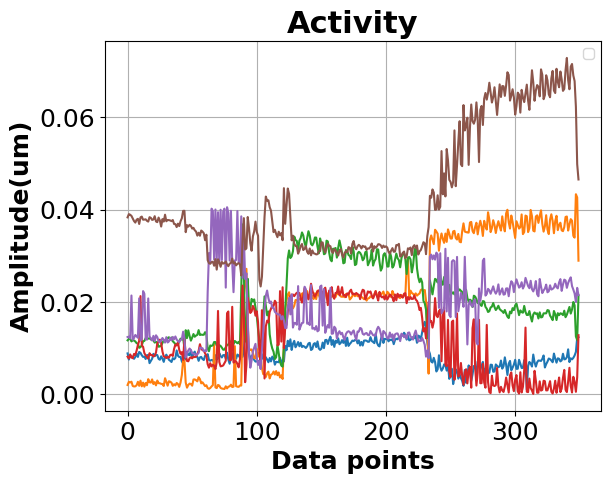

In [4]:

plt.title('Activity', fontsize=22, fontweight='bold')
plt.xlabel('Data points', fontsize=18, fontweight='bold')
plt.ylabel('Amplitude(um)', fontsize=18, fontweight='bold')
plt.grid(True)
plt.legend(['R1_1'])

# Set the text size of the tick labels on both axes
plt.tick_params(axis='both', labelsize=18)
plt.plot(data.index, data[['R1_1','R1_3', 'R1_5', 'R1_7', 'R1_9', 'R1_11']])

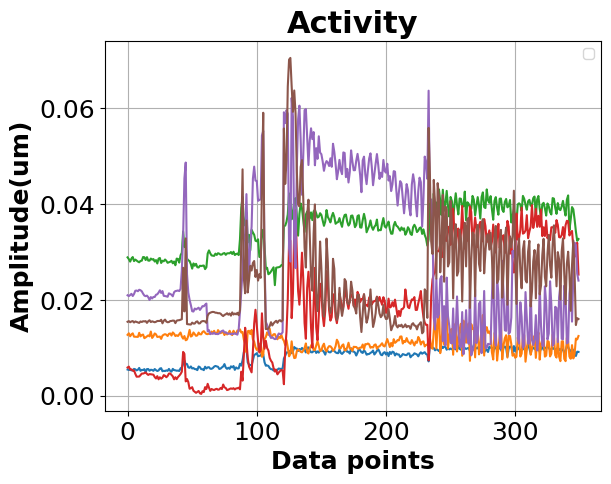

In [5]:
plt.title('Activity', fontsize=22, fontweight='bold')
plt.xlabel('Data points', fontsize=18, fontweight='bold')
plt.ylabel('Amplitude(um)', fontsize=18, fontweight='bold')
plt.grid(True)
plt.legend(['R1_1'])

# Set the text size of the tick labels on both axes
plt.tick_params(axis='both', labelsize=18)
plt.plot(data.index, data[['R4_1','R4_3', 'R4_5', 'R4_7', 'R4_9', 'R4_11', ]])

In [6]:
X = data.drop(['class', 'activity'], axis=1)
y = data['class']

In [7]:
X

,R1_1,R1_3,R1_5,R1_7,R1_9,R1_11,R4_1,R4_3,R4_5,R4_7,R4_9,R4_11
0,0.008886,0.002055,0.011719,0.008174,0.012429,0.038314,0.005472,0.012699,0.028841,0.005891,0.020939,0.015422
1,0.007554,0.002742,0.012014,0.007784,0.012509,0.039015,0.005378,0.013017,0.028469,0.006077,0.020778,0.015560
2,0.008484,0.002614,0.012041,0.008667,0.012113,0.038882,0.005418,0.012402,0.027953,0.005455,0.020992,0.015317
3,0.008215,0.002771,0.011476,0.007999,0.021411,0.038635,0.005304,0.012789,0.028588,0.005506,0.021244,0.015488
4,0.008194,0.001842,0.011720,0.007844,0.011834,0.038085,0.005311,0.013008,0.028912,0.005231,0.020789,0.015566
...,...,...,...,...,...,...,...,...,...,...,...,...
345,0.007923,0.034314,0.020006,0.003829,0.022692,0.069014,0.009460,0.007778,0.038864,0.030928,0.024938,0.032336
346,0.008437,0.033929,0.019295,0.002701,0.021851,0.067793,0.009191,0.008797,0.036716,0.028953,0.031896,0.025333
347,0.009212,0.043322,0.012551,0.000579,0.020022,0.062229,0.008296,0.011916,0.034238,0.029850,0.031446,0.014742
348,0.012278,0.042622,0.011778,0.003737,0.023063,0.049825,0.009187,0.011741,0.032284,0.031878,0.025470,0.016172


In [8]:
# Feature Scaling (empfohlen für LSTM-Modelle)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Überprüfe die Form der Eingabedaten
print("Shape von X_train", X_train.shape)

Shape von X_train (280, 12)


In [11]:

# Definiere Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)


In [12]:

model = Sequential()
model.add(LSTM(512, input_shape=(12, 1), return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(LSTM(128, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

In [13]:

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])


c:\Users\herma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 12, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 256)           787456    
                                                                 
 dropout_1 (Dropout)         (None, 12, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 3

In [15]:
#y_train and y_test are integer class labels (0 or 1)
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [16]:
history = model.fit(
    X_train,
    y_train_encoded,
    batch_size=32,
    epochs=300,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stopping, model_checkpoint]
)



Epoch 1/300
9/9 [==============================] - 8s 341ms/step - loss: 1.6520 - accuracy: 0.7464 - val_loss: 1.2544 - val_accuracy: 0.7571
Epoch 2/300
9/9 [==============================] - 1s 158ms/step - loss: 1.0026 - accuracy: 0.9107 - val_loss: 0.7896 - val_accuracy: 0.9429
Epoch 3/300
9/9 [==============================] - 1s 164ms/step - loss: 0.7307 - accuracy: 0.9464 - val_loss: 0.6594 - val_accuracy: 0.9286
Epoch 4/300
9/9 [==============================] - 1s 161ms/step - loss: 0.5824 - accuracy: 0.9500 - val_loss: 0.4991 - val_accuracy: 0.9571
Epoch 5/300
9/9 [==============================] - 2s 178ms/step - loss: 0.4819 - accuracy: 0.9607 - val_loss: 0.4168 - val_accuracy: 0.9714
Epoch 6/300
9/9 [==============================] - 2s 176ms/step - loss: 0.4320 - accuracy: 0.9536 - val_loss: 0.3686 - val_accuracy: 0.9714
Epoch 7/300
9/9 [==============================] - 2s 175ms/step - loss: 0.3742 - accuracy: 0.9571 - val_loss: 0.3527 - val_accuracy: 0.9571
Epoch 8/300
9

In [17]:
# Lade die besten Gewichtungen des Modells
model.load_weights('best_model.h5')

In [18]:
# Evaluieren des Modells
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
#print(y_pred_labels)


3/3 [==============================] - 1s 33ms/step


In [19]:
threshold = 0.5
y_pred_labels_binary = (y_pred_labels >= threshold).astype(int)

In [20]:
# Berechne die Genauigkeit
accuracy = accuracy_score(y_test, y_pred_labels_binary)

In [21]:
for pred_label, true_label in zip(y_pred_labels_binary, y_test):
    print("Predicted Class:", pred_label)
    print("True Class:", true_label)
    print("---------------------------------------------------")
print("accuracy", accuracy)


Predicted Class: 1
True Class: 1
---------------------------------------------------
Predicted Class: 1
True Class: 2
---------------------------------------------------
Predicted Class: 1
True Class: 2
---------------------------------------------------
Predicted Class: 1
True Class: 2
---------------------------------------------------
Predicted Class: 1
True Class: 1
---------------------------------------------------
Predicted Class: 1
True Class: 2
---------------------------------------------------
Predicted Class: 1
True Class: 2
---------------------------------------------------
Predicted Class: 1
True Class: 1
---------------------------------------------------
Predicted Class: 1
True Class: 2
---------------------------------------------------
Predicted Class: 1
True Class: 1
---------------------------------------------------
Predicted Class: 0
True Class: 0
---------------------------------------------------
Predicted Class: 1
True Class: 1
--------------------------------

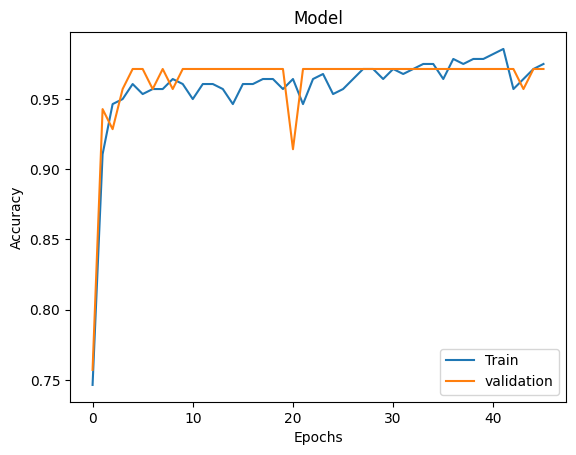

In [22]:
# Plot der Trainings- und Validierungsgenauigkeit
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'validation'], loc='lower right')
plt.show()